In [18]:
import torch
import torchvision 
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import sklearn
from sklearn import datasets
from torch.utils.data import DataLoader, TensorDataset



* `torchvision.datasets` - get datasets and data loading function for computer vision here
* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems..
* `

In [19]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [20]:
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

* `Fashion MNist dataset` 
- `Grayscale images of Fashion`

In [105]:
from torchvision.datasets import FashionMNIST

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(), 

])
test_transforms = transforms.Compose([
    transforms.ToTensor(),

])

train_dataset = FashionMNIST(
    root="data",
    train=True,
    transform=train_transforms, 
    download=True
)

test_dataset = FashionMNIST(
    root="data",
    train=False,
    transform=test_transforms, 
    download=True
)



torch.Size([1, 28, 28]) 9


Text(0.5, 1.0, 'Ankle boot')

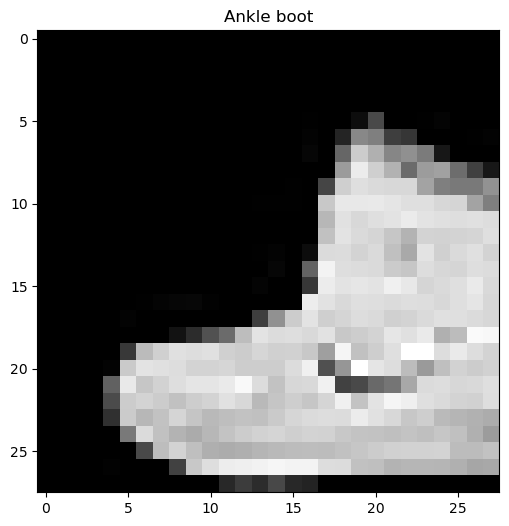

In [76]:
class_names, class_to_idx = train_dataset.classes, train_dataset.class_to_idx
image,label = train_dataset[0]
print(image.shape, label)
plt.figure(figsize=(12,6))
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])

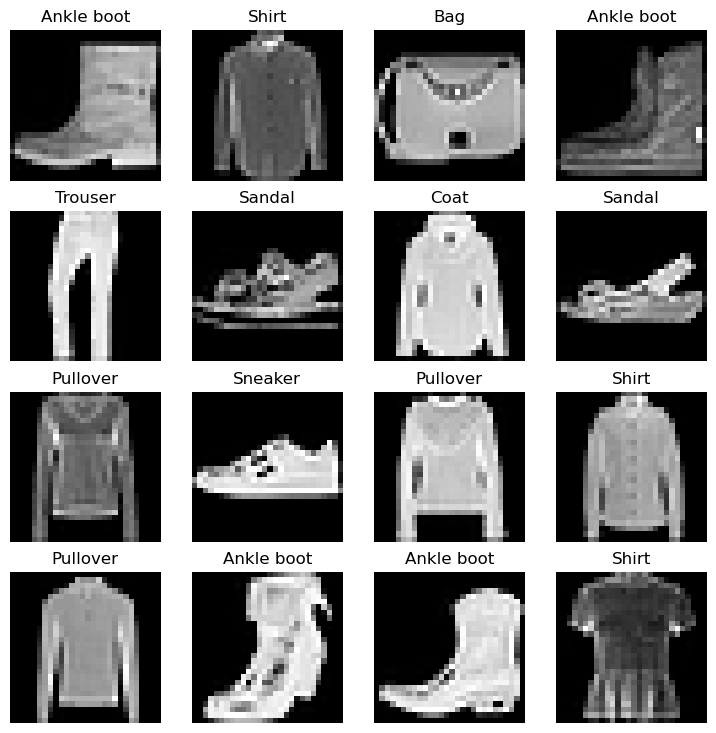

In [23]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data), size=(1,)).item()
    img,label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

In [24]:
train_dataloader = DataLoader(train_data, batch_size=32,shuffle=True )
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)


In [25]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

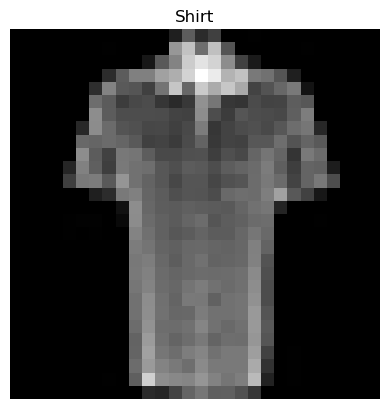

In [26]:
torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label.item()])
plt.axis('off')



In [27]:

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [28]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(class_names) # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with 

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [29]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_0.parameters(), lr=0.1)

In [30]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float,device:torch.device=None):
    if device is None:
        print(f"Training took: {end-start:.3f} seconds")
    else:
        print(f"Training on {device} took: {end-start:.3f} seconds")
    return end-start

In [31]:
from tqdm.auto import tqdm
device = "mps" if torch.backends.mps.is_available() else "cpu"


torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 10
model_0.to(device)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n-------------------------------")
    train_loss = 0

    for batch, (X,y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        model_0.train()
        y_pred = model_0(X)
        
        loss = loss_fn(y_pred,y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if batch % 400 == 0:
        print(f"Batch {batch} Loss: {loss.item()}")
    
    train_loss /= len(train_dataloader)
    
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            test_pred = model_0(X)
            
            test_loss += loss_fn(test_pred,y)
            
            
            test_acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        
        test_acc /= len(test_dataloader)

    print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
    
end_time = timer()
print_train_time(train_time_start_on_cpu, end_time,device=str(next(model_0.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 
-------------------------------
Train loss: 0.5904 | Test loss: 0.5095 | Test accuracy: 82.0387
Epoch: 1 
-------------------------------
Train loss: 0.4763 | Test loss: 0.4799 | Test accuracy: 83.1969
Epoch: 2 
-------------------------------
Train loss: 0.4550 | Test loss: 0.4766 | Test accuracy: 83.4265
Epoch: 3 
-------------------------------
Train loss: 0.4425 | Test loss: 0.4631 | Test accuracy: 83.7460
Epoch: 4 
-------------------------------
Train loss: 0.4358 | Test loss: 0.4687 | Test accuracy: 83.2668
Epoch: 5 
-------------------------------
Train loss: 0.4291 | Test loss: 0.4589 | Test accuracy: 83.6362
Epoch: 6 
-------------------------------
Train loss: 0.4248 | Test loss: 0.4877 | Test accuracy: 83.3167
Epoch: 7 
-------------------------------
Train loss: 0.4227 | Test loss: 0.4722 | Test accuracy: 83.3766
Epoch: 8 
-------------------------------
Train loss: 0.4203 | Test loss: 0.4713 | Test accuracy: 83.4565
Epoch: 9 
-------------------------------
Trai

32.201480333998916

In [38]:
class Model(nn.Module):
    def __init__(self,input_shape: int, hidden_units:int,output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units), 
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units),  
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)  
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=hidden_units * 2, out_channels=hidden_units * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)  
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),  
            nn.Linear(in_features=hidden_units * 2 * 7 * 7, out_features=256),
            nn.ReLU(),
            nn.Dropout(0.5), 
            nn.Linear(in_features=256, out_features=output_shape)
        )
    
    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)
    

In [39]:
torch.manual_seed(42)
device = "mps" if torch.backends.mps.is_available() else "cpu"
model = Model(input_shape=1,hidden_units=32,output_shape=len(class_names)).to(device)


In [40]:
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n-------------------------------")
    train_loss = 0

    for batch, (X,y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        model.train()
        y_pred = model(X)
        
        loss = loss_fn(y_pred,y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if batch % 400 == 0:
        print(f"Batch {batch} Loss: {loss.item()}")
    
    train_loss /= len(train_dataloader)
    
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            X = X.to(device)
            y = y.to(device)
            test_pred = model(X)
            
            test_loss += loss_fn(test_pred,y)
            
            
            test_acc += accuracy_fn(y_true=y,y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        
        test_acc /= len(test_dataloader)

    print(f"Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
    
end_time = timer()
print_train_time(train_time_start_on_cpu, end_time,device=str(next(model_0.parameters()).device))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 
-------------------------------
Train loss: 0.4614 | Test loss: 0.3064 | Test accuracy: 88.9277
Epoch: 1 
-------------------------------
Train loss: 0.3164 | Test loss: 0.2585 | Test accuracy: 90.2656
Epoch: 2 
-------------------------------
Train loss: 0.2763 | Test loss: 0.2413 | Test accuracy: 90.8546
Epoch: 3 
-------------------------------
Train loss: 0.2518 | Test loss: 0.2208 | Test accuracy: 92.0827
Epoch: 4 
-------------------------------
Train loss: 0.2318 | Test loss: 0.2120 | Test accuracy: 92.1426
Epoch: 5 
-------------------------------
Train loss: 0.2240 | Test loss: 0.2119 | Test accuracy: 92.4321
Epoch: 6 
-------------------------------
Train loss: 0.2087 | Test loss: 0.1993 | Test accuracy: 92.8415
Epoch: 7 
-------------------------------
Train loss: 0.1978 | Test loss: 0.1967 | Test accuracy: 92.9912
Epoch: 8 
-------------------------------
Train loss: 0.1881 | Test loss: 0.1950 | Test accuracy: 92.8514
Epoch: 9 
-------------------------------
Trai

1799.7730634590007

In [106]:
from tqdm.auto import tqdm

y_preds = []
model.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        y_pred = y_logits.argmax(dim=1)
        y_preds.append(y_pred.cpu()) 
y_preds = torch.cat(y_preds)
y_preds, len(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

(tensor([9, 2, 1,  ..., 8, 1, 5]), 10000)

In [101]:
test_dataset.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

In [107]:

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
class_names = test_dataset.classes
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds, target=test_dataset.targets)

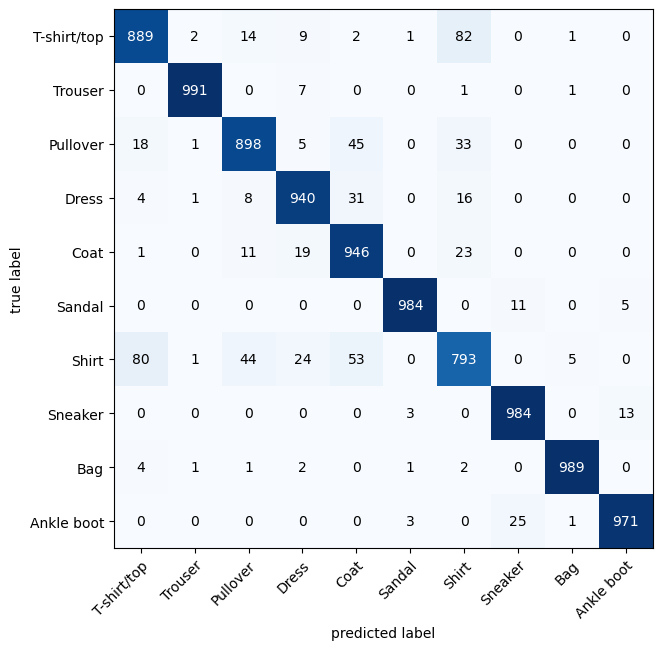

In [108]:
confmat_tensor
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), figsize=(10,7), class_names=class_names)

In [83]:
print(test_dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [113]:
altered_test_dataset_classes = [
    "T-shirt/Shirt", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Sneaker", "Bag", "Ankle boot"
]
label_mapping = {
    0:0,
    1:1,
    2:2,
    3:3,
    4:4,
    5:5,
    6:0,
    7:6,
    8:7,
    9:8
}
altered_test_dataset_targets = torch.tensor([label_mapping[label.item()] for label in test_dataset.targets])
altered_y_preds = torch.tensor([label_mapping[label.item()] for label in y_preds])

In [114]:
altered_test_dataset_targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [115]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(altered_test_dataset_classes))
confmat_tensor = confmat(preds=altered_y_preds, target=altered_test_dataset_targets)


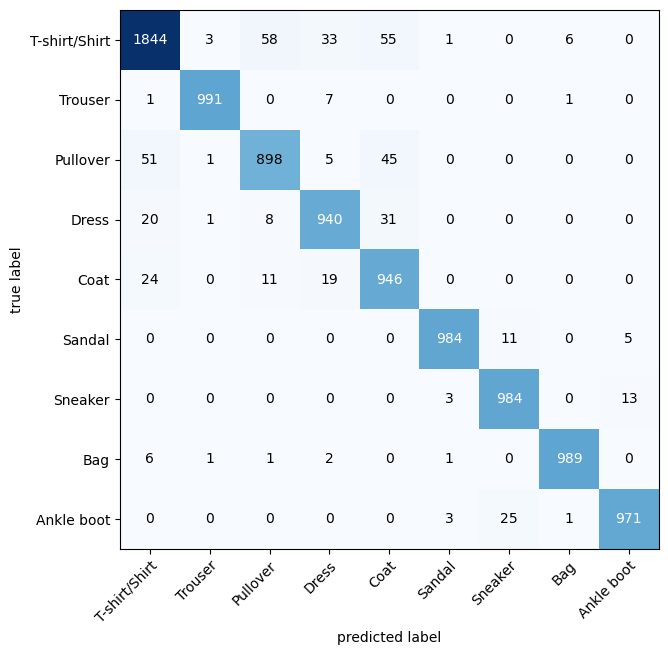

In [116]:
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), figsize=(10,7), class_names=altered_test_dataset_classes)

In [119]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)
MODEL_NAME = "03_pytorch_CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),f =MODEL_SAVE_PATH)

Saving model to models/03_pytorch_CNN.pth
